In [ ]:

!pip install ultralytics
!pip install xml.etree.ElementTree
import os
import shutil
import random
from xml.etree import ElementTree as ET
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.2 MB/s eta 0:00:00a 0:00:01
ERROR: Could not find a version that satisfies the requirement xml.etree.ElementTree (from versions: none)
ERROR: No matching distribution found for xml.etree.ElementTree
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:

data_path = '/kaggle/input/maskface/'
annotations_path = os.path.join(data_path, 'annotations')
images_path = os.path.join(data_path, 'images')

output_dir = '/kaggle/working/yolo_dataset'
train_images_dir = os.path.join(output_dir, 'images/train')
val_images_dir = os.path.join(output_dir, 'images/val')
train_labels_dir = os.path.join(output_dir, 'labels/train')
val_labels_dir = os.path.join(output_dir, 'labels/val')

os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)


class_map = {
    'with_mask': 0,
    'without_mask': 1,
}

In [ ]:

def convert_xml_to_yolo(xml_file, image_width, image_height):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    labels = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        if class_name not in class_map:
            continue  
        class_id = class_map[class_name]
        
        bndbox = obj.find('bndbox')
        xmin = float(bndbox.find('xmin').text)
        ymin = float(bndbox.find('ymin').text)
        xmax = float(bndbox.find('xmax').text)
        ymax = float(bndbox.find('ymax').text)
        
        x_center = (xmin + xmax) / 2 / image_width
        y_center = (ymin + ymax) / 2 / image_height
        width = (xmax - xmin) / image_width
        height = (ymax - ymin) / image_height
        
        labels.append(f"{class_id} {x_center} {y_center} {width} {height}")
    
    return labels


xml_files = [f for f in os.listdir(annotations_path) if f.endswith('.xml')]
random.shuffle(xml_files)


split_idx = int(0.8 * len(xml_files))
train_xmls = xml_files[:split_idx]
val_xmls = xml_files[split_idx:]

def process_split(xml_list, images_dir, labels_dir):
    for xml_file in xml_list:
        xml_path = os.path.join(annotations_path, xml_file)
        image_file = xml_file.replace('.xml', '.png')  
        image_path = os.path.join(images_path, image_file)
        
        if not os.path.exists(image_path):
            continue
        

        from PIL import Image
        img = Image.open(image_path)
        width, height = img.size
        
        labels = convert_xml_to_yolo(xml_path, width, height)
        
        if labels:
            shutil.copy(image_path, images_dir)
            
            label_file = xml_file.replace('.xml', '.txt')
            label_path = os.path.join(labels_dir, label_file)
            with open(label_path, 'w') as f:
                f.write('\n'.join(labels))


process_split(train_xmls, train_images_dir, train_labels_dir)
process_split(val_xmls, val_images_dir, val_labels_dir)

print(f"Train samples: {len(train_xmls)}, Val samples: {len(val_xmls)}")

Train samples: 682, Val samples: 171


In [ ]:
yaml_content = """
path: /kaggle/working/yolo_dataset
train: images/train
val: images/val

nc: 2  # Number of classes
names: ['with_mask', 'without_mask']
"""

yaml_path = '/kaggle/working/dataset.yaml'
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

In [ ]:

model = YOLO('yolov8n.pt') 

results = model.train(
    data=yaml_path,
    epochs=30,              
    imgsz=640,              
    batch=32,               
    workers=8,             
    cache='disk',                                 
    device=0,               
    patience=10,
    name='mask_detection_fast',
)

Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=disk, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=mask_detection_fast, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, pl

In [ ]:

val_results = model.val()

print(val_results)


Ultralytics 8.4.5 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 73 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4251.1±1136.0 MB/s, size: 482.2 KB)
val: Scanning /kaggle/working/yolo_dataset/labels/val.cache... 168 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 168/168 70.5Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 3.6it/s 3.1s0.1s
                   all        168        892      0.851      0.793      0.862       0.55
             with_mask        156        695      0.882      0.845       0.91        0.6
          without_mask         61        197       0.82      0.742      0.814        0.5
Speed: 1.7ms preprocess, 10.8ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to /kaggle/working/runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: arr

In [ ]:
test_image_path = '/kaggle/working/yolo_dataset/images/val/' 

inference_results = model(test_image_path, save=True)  # Saves detected images in runs/detect/

import cv2
from IPython.display import Image, display

def detect_mask(image_path):
    results = model(image_path)
    for result in results:
        result.show() 


image 1/168 /kaggle/working/yolo_dataset/images/val/maksssksksss1.png: 256x640 7 with_masks, 1 without_mask, 37.9ms
image 2/168 /kaggle/working/yolo_dataset/images/val/maksssksksss103.png: 480x640 4 with_masks, 36.8ms
image 3/168 /kaggle/working/yolo_dataset/images/val/maksssksksss105.png: 448x640 9 with_masks, 36.4ms
image 4/168 /kaggle/working/yolo_dataset/images/val/maksssksksss106.png: 448x640 (no detections), 5.8ms
image 5/168 /kaggle/working/yolo_dataset/images/val/maksssksksss108.png: 384x640 6 with_masks, 1 without_mask, 37.8ms
image 6/168 /kaggle/working/yolo_dataset/images/val/maksssksksss11.png: 448x640 23 with_masks, 2 without_masks, 6.3ms
image 7/168 /kaggle/working/yolo_dataset/images/val/maksssksksss117.png: 640x512 1 with_mask, 35.9ms
image 8/168 /kaggle/working/yolo_dataset/images/val/maksssksksss13.png: 384x640 5 with_masks, 6.1ms
image 9/168 /kaggle/working/yolo_dataset/images/val/maksssksksss130.png: 640x544 2 with_masks, 2 without_masks, 36.5ms
image 10/168 /kaggl

In [ ]:

print("Training complete. Check runs/train/ for plots and metrics.")
print("For real-world testing, use the detect_mask function with uploaded images.")
print("Evaluation metrics:", val_results.box.map)  

Training complete. Check runs/train/ for plots and metrics.
For real-world testing, use the detect_mask function with uploaded images.
Evaluation metrics: 0.5498062491794158


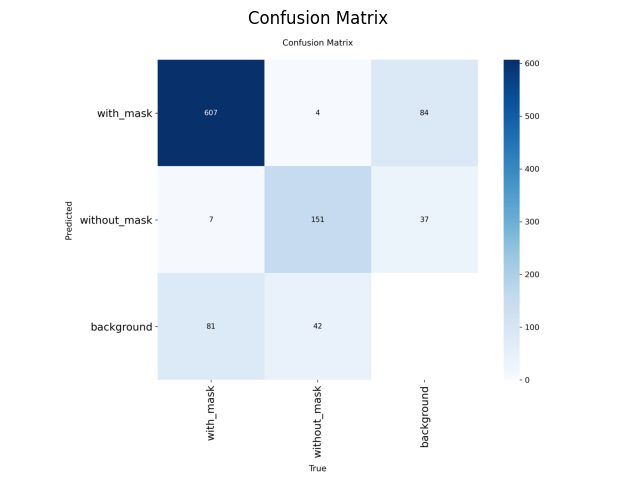

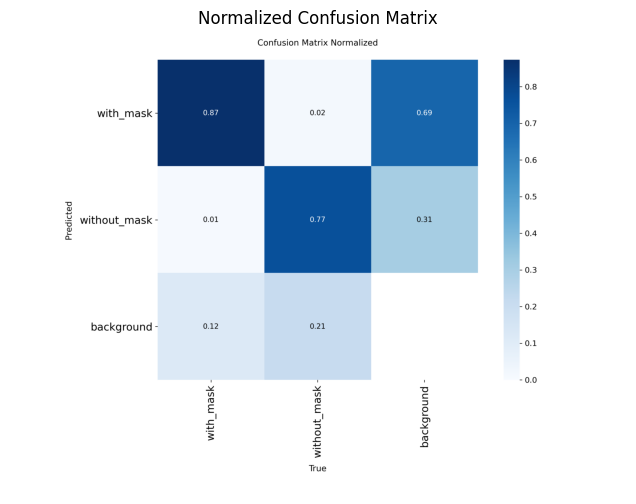

In [ ]:

import matplotlib.pyplot as plt
from PIL import Image

conf_matrix_path = '/kaggle/working/runs/detect/mask_detection_fast/confusion_matrix.png'
conf_matrix_norm_path = '/kaggle/working/runs/detect/mask_detection_fast/confusion_matrix_normalized.png'


img = Image.open(conf_matrix_path)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Confusion Matrix')
plt.show()

img_norm = Image.open(conf_matrix_norm_path)
plt.figure(figsize=(8, 6))
plt.imshow(img_norm)
plt.axis('off')
plt.title('Normalized Confusion Matrix')
plt.show()

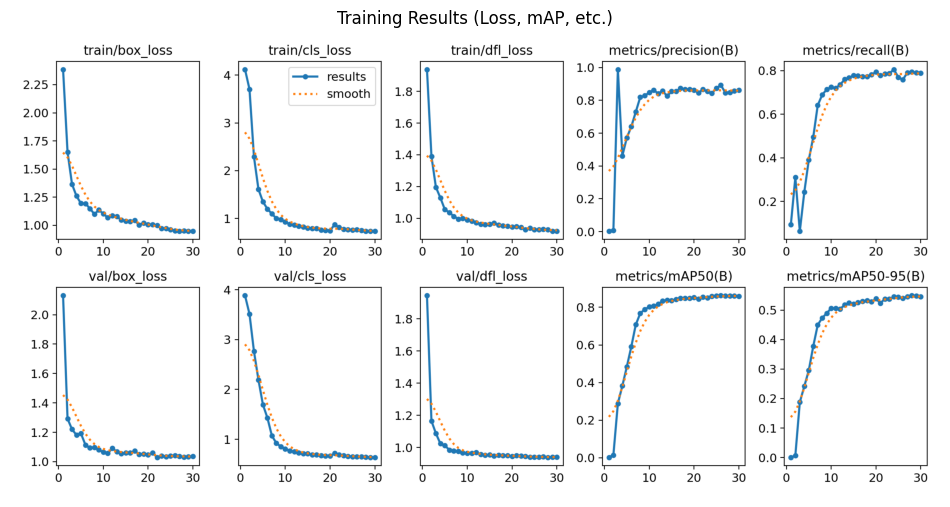

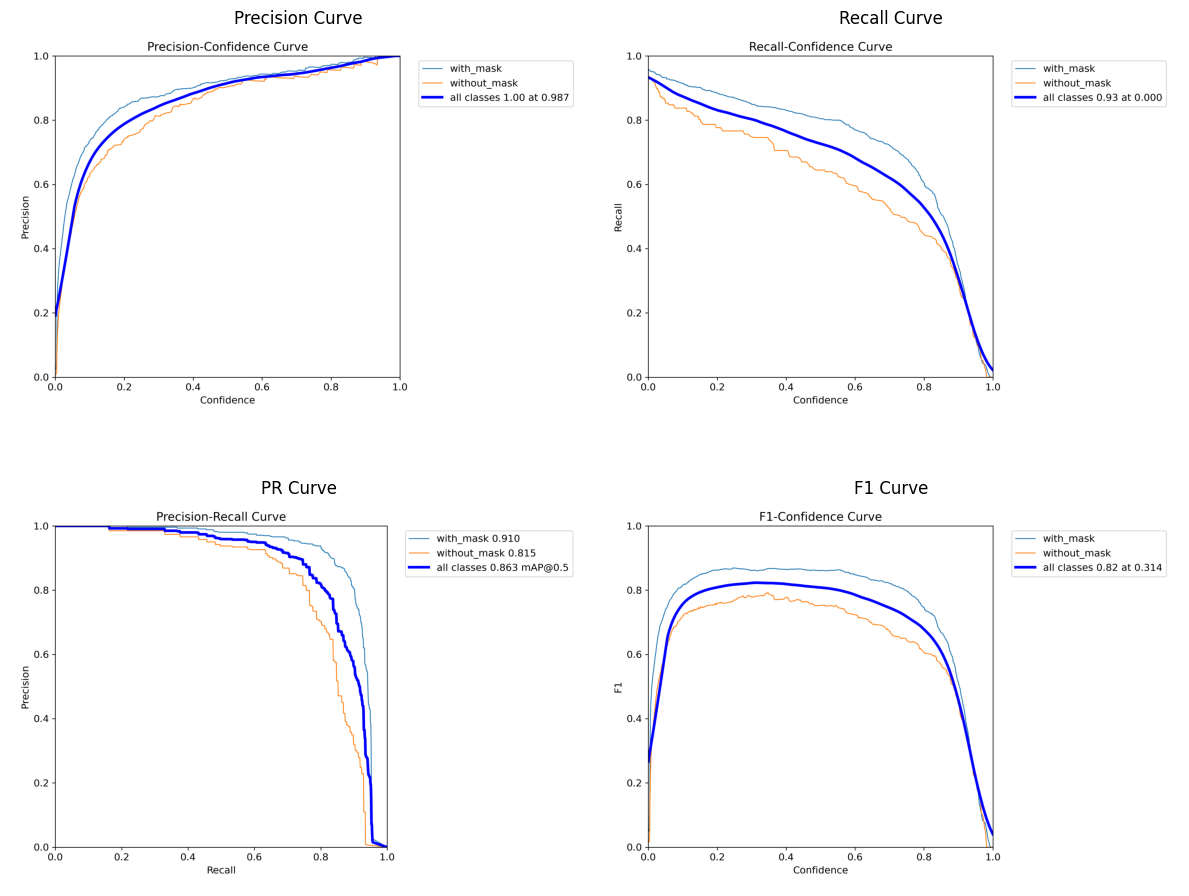

In [ ]:

results_path = '/kaggle/working/runs/detect/mask_detection_fast/results.png'
p_curve_path = '/kaggle/working/runs/detect/mask_detection_fast/BoxP_curve.png'
r_curve_path = '/kaggle/working/runs/detect/mask_detection_fast/BoxR_curve.png'
pr_curve_path = '/kaggle/working/runs/detect/mask_detection_fast/BoxPR_curve.png'
f1_curve_path = '/kaggle/working/runs/detect/mask_detection_fast/BoxF1_curve.png'

img_results = Image.open(results_path)
plt.figure(figsize=(12, 8))
plt.imshow(img_results)
plt.axis('off')
plt.title('Training Results (Loss, mAP, etc.)')
plt.show()

curves = [p_curve_path, r_curve_path, pr_curve_path, f1_curve_path]
titles = ['Precision Curve', 'Recall Curve', 'PR Curve', 'F1 Curve']

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
for i, ax in enumerate(axs.flatten()):
    img = Image.open(curves[i])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(titles[i])
plt.tight_layout()
plt.show()

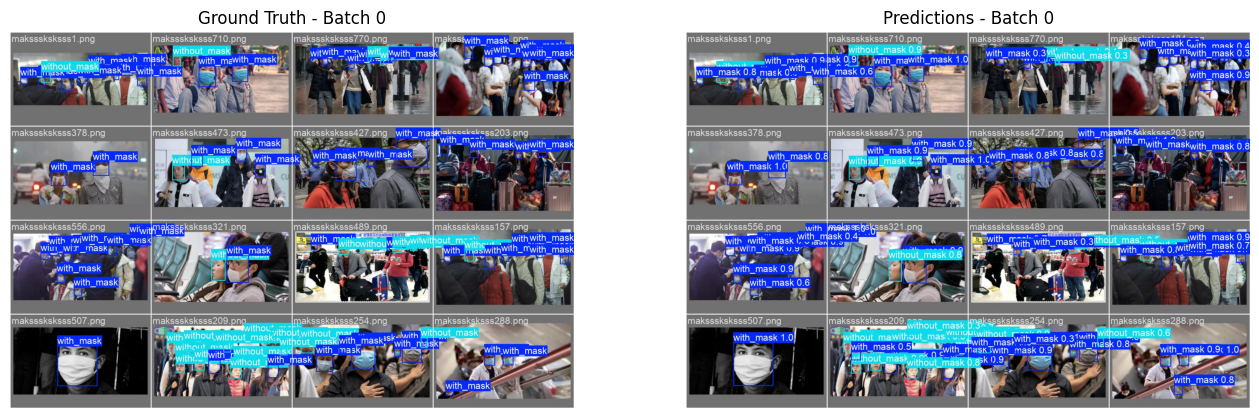

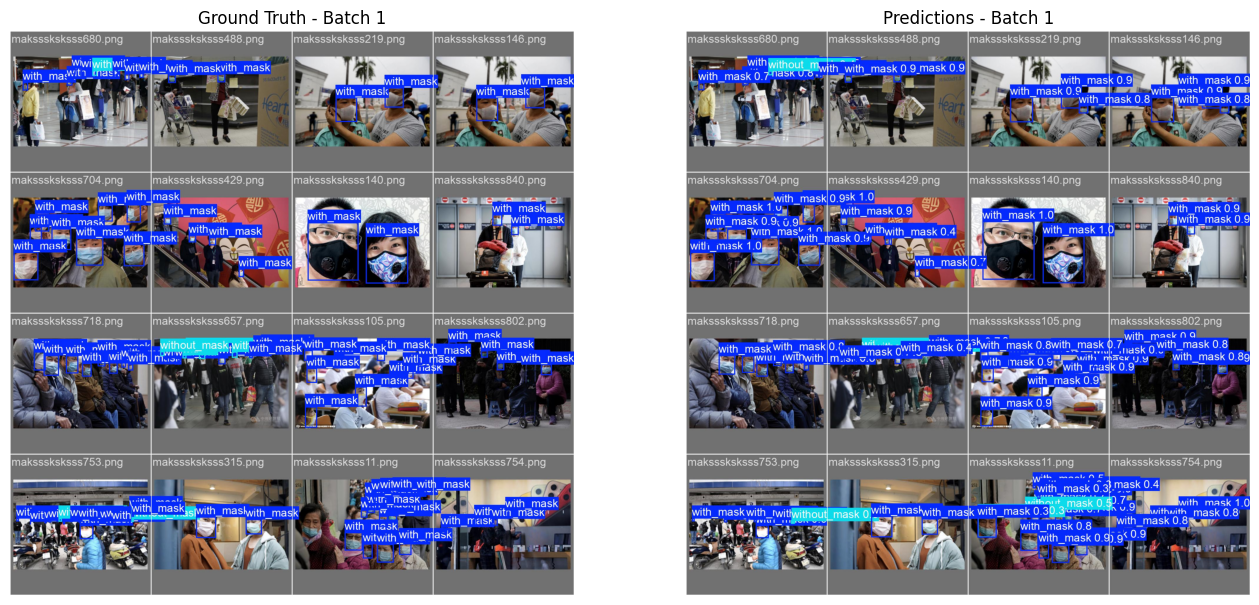

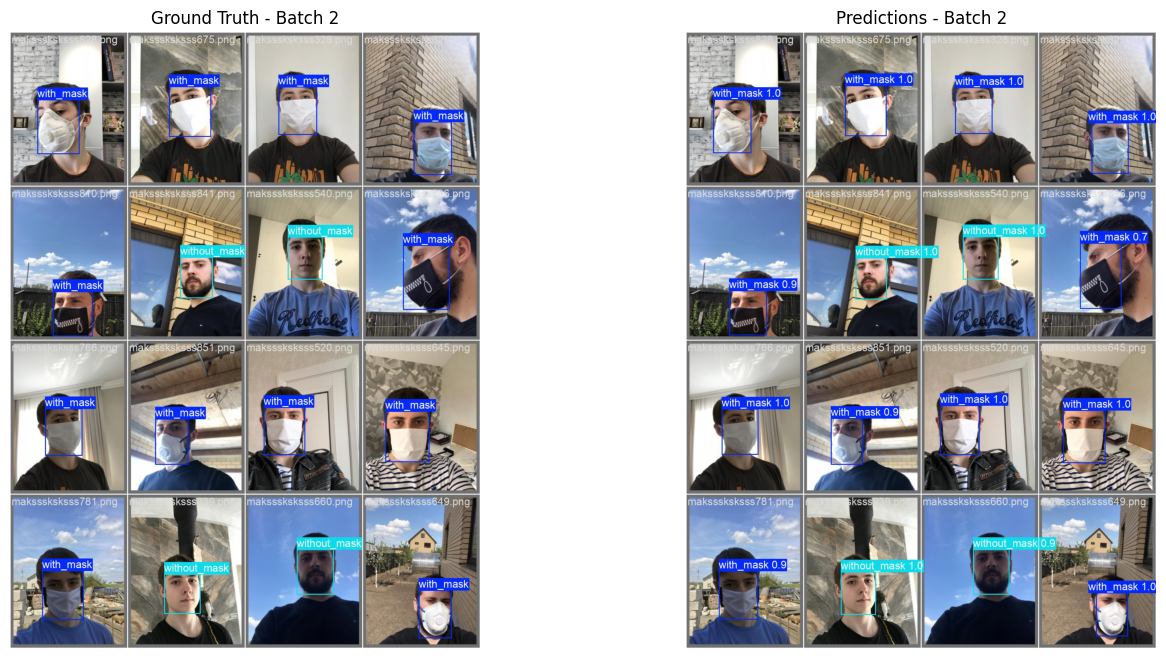

In [ ]:

import matplotlib.pyplot as plt
from PIL import Image

batch_ids = [0, 1, 2] 

for batch_id in batch_ids:
    labels_path = f'/kaggle/working/runs/detect/mask_detection_fast/val_batch{batch_id}_labels.jpg'
    pred_path = f'/kaggle/working/runs/detect/mask_detection_fast/val_batch{batch_id}_pred.jpg'
    

    img_labels = Image.open(labels_path)
    img_pred = Image.open(pred_path)
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    axs[0].imshow(img_labels)
    axs[0].axis('off')
    axs[0].set_title(f'Ground Truth - Batch {batch_id}')
    
    axs[1].imshow(img_pred)
    axs[1].axis('off')
    axs[1].set_title(f'Predictions - Batch {batch_id}')
    
    plt.show()